<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/mvi</code>


In [10]:
import sys
sys.path.insert(1, '../../../../utils')
from numpy import ndarray, array
from pandas import read_csv, DataFrame, concat
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multibar_chart, plot_multiline_chart, plot_evaluation_results, get_variable_types
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier


In [11]:
# Load data
train_filename = "../../data/prepared/encoding/flight_train_enc.csv"
test_filename = "../../data/prepared/encoding/flight_test_enc.csv"
train_data: DataFrame = read_csv(train_filename, na_values="")
test_data: DataFrame = read_csv(test_filename, na_values="")

print(train_data.shape, test_data.shape)

(140000, 182) (60000, 182)


In [12]:
# Identify variable types
vars_types = get_variable_types(train_data)

numeric_vars = vars_types["numeric"].copy()
binary_vars  = vars_types["binary"].copy()

print("Numeric:", len(numeric_vars))
print("Binary:", len(binary_vars))

Numeric: 32
Binary: 149


In [13]:
# Drop all-NaN columns
all_nan_cols = train_data.columns[train_data.isna().all()].tolist()
print("Dropping all-NaN columns:", all_nan_cols)

if len(all_nan_cols) > 0:
    train_data = train_data.drop(columns=all_nan_cols)
    test_data  = test_data.drop(columns=all_nan_cols)

target = "Cancelled"

# Find columns with NaN values
train_nan_cols = train_data.columns[train_data.isna().any()].tolist()
print("Columns with NaN in train data:", train_nan_cols)

# Print number of missing values for column Tail_Number
if "Tail_Number" in train_nan_cols:
    print("Missing values in 'Tail_Number':", train_data["Tail_Number"].isna().sum())
    # Percent of missing values
    print("Percent missing in 'Tail_Number':", train_data["Tail_Number"].isna().mean() * 100)

Dropping all-NaN columns: []
Columns with NaN in train data: ['Tail_Number']
Missing values in 'Tail_Number': 1053
Percent missing in 'Tail_Number': 0.7521428571428571


### Imputation Method 1 - frequent strategy

In [14]:
def mvi_simple(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled"
) -> tuple[DataFrame, DataFrame]:
    train = train.copy()
    test  = test.copy()

    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    numeric_cols = train_X.select_dtypes(include="number").columns.tolist()
    other_cols   = [c for c in train_X.columns if c not in numeric_cols]

    binary_cols: list[str] = []
    for col in numeric_cols:
        uniq = set(train_X[col].dropna().unique())
        if uniq.issubset({0, 1}):
            binary_cols.append(col)

    continuous_cols = [c for c in numeric_cols if c not in binary_cols]

    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    if continuous_cols:
        imp_num = SimpleImputer(strategy="mean")
        tr_num = DataFrame(
            imp_num.fit_transform(train_X[continuous_cols]),
            columns=continuous_cols,
            index=train_X.index,
        )
        te_num = DataFrame(
            imp_num.transform(test_X[continuous_cols]),
            columns=continuous_cols,
            index=test_X.index,
        )
        parts_tr.append(tr_num)
        parts_te.append(te_num)

    if binary_cols:
        imp_bin = SimpleImputer(strategy="most_frequent")
        tr_bin = DataFrame(
            imp_bin.fit_transform(train_X[binary_cols]),
            columns=binary_cols,
            index=train_X.index,
        )
        te_bin = DataFrame(
            imp_bin.transform(test_X[binary_cols]),
            columns=binary_cols,
            index=test_X.index,
        )
        parts_tr.append(tr_bin)
        parts_te.append(te_bin)

    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out


### Specific Method 1 - TailNumber

In [15]:
def mvi_simple_tail_number(
    train: DataFrame,
    test: DataFrame,
    impute_col: str = "Tail_Number",
    target: str = "Cancelled"
) -> tuple[DataFrame, DataFrame]:
    """
    Imputes missing values in the specified numerical 'impute_col' 
    (default: 'Tail_Number') using the MEAN calculated from the training set.
    """
    train = train.copy()
    test  = test.copy()

    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")
    
    if impute_col not in train.columns or impute_col not in test.columns:
        raise KeyError(f"Impute column '{impute_col}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    other_cols = [c for c in train.columns if c not in [target, impute_col]]

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    imp_num = SimpleImputer(strategy="mean")
    
    tr_num = DataFrame(
        imp_num.fit_transform(train_X[[impute_col]]),
        columns=[impute_col],
        index=train_X.index,
    )
    te_num = DataFrame(
        imp_num.transform(test_X[[impute_col]]),
        columns=[impute_col],
        index=test_X.index,
    )
    parts_tr.append(tr_num)
    parts_te.append(te_num)

    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out

### Imputation Method 2 - KNN strategy

In [16]:
def mvi_knn(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    k: int = 5
) -> tuple[DataFrame, DataFrame]:
    train = train.copy()
    test  = test.copy()

    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    numeric_cols = train_X.select_dtypes(include="number").columns.tolist()
    other_cols   = [c for c in train_X.columns if c not in numeric_cols]

    binary_cols: list[str] = []
    for col in numeric_cols:
        uniq = set(train_X[col].dropna().unique())
        if uniq.issubset({0, 1}):
            binary_cols.append(col)

    continuous_cols = [c for c in numeric_cols if c not in binary_cols]

    knn_cols = numeric_cols

    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    if knn_cols:
        imp_knn = KNNImputer(n_neighbors=k)
        tr_knn = DataFrame(
            imp_knn.fit_transform(train_X[knn_cols]),
            columns=knn_cols,
            index=train_X.index,
        )
        te_knn = DataFrame(
            imp_knn.transform(test_X[knn_cols]),
            columns=knn_cols,
            index=test_X.index,
        )

        for col in binary_cols:
            tr_knn[col] = tr_knn[col].round().astype(int)
            te_knn[col] = te_knn[col].round().astype(int)

        parts_tr.append(tr_knn)
        parts_te.append(te_knn)

    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out

### Specific Method 2 - TailNumber

In [17]:
def mvi_knn_tail_number(
    train: DataFrame,
    test: DataFrame,
    impute_col: str = "Tail_Number",
    target: str = "Cancelled",
    k: int = 5
) -> tuple[DataFrame, DataFrame]:
    train = train.copy()
    test  = test.copy()

    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")
        
    if impute_col not in train.columns or impute_col not in test.columns:
        raise KeyError(f"Impute column '{impute_col}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    numeric_cols = train_X.select_dtypes(include="number").columns.tolist()
    knn_cols = [c for c in numeric_cols]
    
    other_cols = [c for c in train_X.columns if c not in numeric_cols]
    
    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    if knn_cols:
        imp_knn = KNNImputer(n_neighbors=k)
        
        tr_knn = DataFrame(
            imp_knn.fit_transform(train_X[knn_cols]),
            columns=knn_cols,
            index=train_X.index,
        )
        
        te_knn = DataFrame(
            imp_knn.transform(test_X[knn_cols]),
            columns=knn_cols,
            index=test_X.index,
        )

        parts_tr.append(tr_knn)
        parts_te.append(te_knn)

    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out

# Evaluation

In [18]:
train_simple, test_simple = mvi_simple(train_data, test_data, target=target)
train_knn,    test_knn    = mvi_knn(train_data, test_data, target=target, k=10) # k=10 chosen arbitrarily

print("Simple MVI shapes:", train_simple.shape, test_simple.shape)
print("KNN    MVI shapes:", train_knn.shape,    test_knn.shape)

Simple MVI shapes: (140000, 182) (60000, 182)
KNN    MVI shapes: (140000, 182) (60000, 182)


In [19]:
file_tag_simple = "flight_mvi_simple"
file_tag_knn    = "flight_mvi_knn"

# Eval copies
train_simple_eval = train_simple.copy()
test_simple_eval  = test_simple.copy()

train_knn_eval = train_knn.copy()
test_knn_eval  = test_knn.copy()

# Drop FlightDate columns from ALL eval sets
datetime_cols = train_simple_eval.select_dtypes(include="datetime64[ns]").columns.tolist()
print("Datetime columns dropped from eval:", datetime_cols)

for df in [train_simple_eval, test_simple_eval, train_knn_eval, test_knn_eval]:
    df.drop(columns=datetime_cols, errors="ignore", inplace=True)
    df[target] = df[target].astype(int)

# Validation
print("Same columns in SIMPLE vs KNN eval?",
      set(train_simple_eval.columns) == set(train_knn_eval.columns))

print("NaNs SIMPLE train/test:",
      train_simple_eval.isna().sum().sum(),
      test_simple_eval.isna().sum().sum())

print("NaNs KNN train/test:",
      train_knn_eval.isna().sum().sum(),
      test_knn_eval.isna().sum().sum())

Datetime columns dropped from eval: ['FlightDate']
Same columns in SIMPLE vs KNN eval? True
NaNs SIMPLE train/test: 0 0
NaNs KNN train/test: 0 0


In [9]:
# Local helper functions
def evaluate_approach(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    metric: str = "recall",
) -> dict[str, list[float]]:
    trn = train.copy()
    tst = test.copy()

    trnY = trn.pop(target).values
    trnX: ndarray = trn.values
    tstY = tst.pop(target).values
    tstX: ndarray = tst.values

    eval_dict: dict[str, list[float]] = {}

    eval_NB  = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN = run_KNN(trnX, trnY, tstX, tstY, metric=metric)

    if eval_NB and eval_KNN:
        for met in CLASS_EVAL_METRICS:
            eval_dict[met] = [eval_NB[met], eval_KNN[met]]

    return eval_dict


def print_eval_table(eval_dict: dict[str, list[float]]):
    print(f"{'Metric':12s} | {'NB':>10s} | {'KNN':>10s}")
    print("-" * 40)
    for metric, vals in eval_dict.items():
        nb, knn = vals
        print(f"{metric:12s} | {nb:10.4f} | {knn:10.4f}")
    print()

Couldn't run MultinomialNB
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.9338 |     0.9514
recall       |     0.0993 |     0.0596
precision    |     0.0493 |     0.0502
auc          |     0.5266 |     0.5162
f1           |     0.0659 |     0.0545



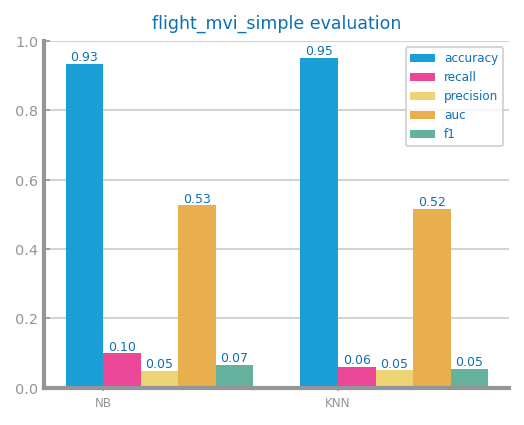

Couldn't run MultinomialNB
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.9338 |     0.9514
recall       |     0.0993 |     0.0596
precision    |     0.0493 |     0.0502
auc          |     0.5266 |     0.5162
f1           |     0.0659 |     0.0545



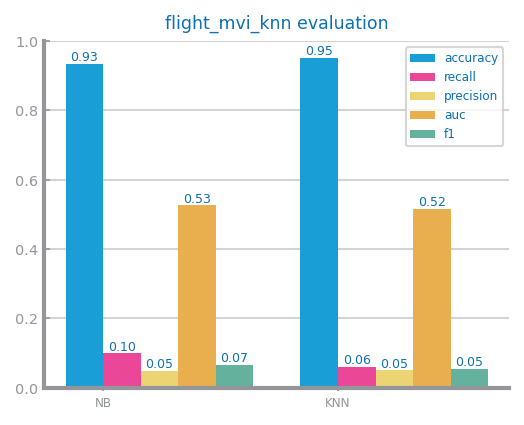

In [13]:

# Simple-imputer MVI
figure()
eval_simple = evaluate_approach(
    train_simple_eval.copy(),
    test_simple_eval.copy(),
    target=target,
    metric="recall", 
)
print_eval_table(eval_simple)
plot_multibar_chart(
    ["NB", "KNN"],
    eval_simple,
    title=f"{file_tag_simple} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/mvi/{file_tag_simple}_NB_KNN_recall_eval.png")
show()

# KNN-imputer MVI
figure()
eval_knn = evaluate_approach(
    train_knn_eval.copy(),
    test_knn_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_knn)
plot_multibar_chart(
    ["NB", "KNN"],
    eval_knn,
    title=f"{file_tag_knn} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/mvi/{file_tag_knn}_NB_KNN_recall_eval.png")
show()


In [21]:
file_tag = "flight_mvi_simple"
target = "Cancelled"
eval_metric = "recall"   

# Data from the already-prepared simple_mvi eval sets
train_df = train_simple_eval.copy()
test_df  = test_simple_eval.copy()

trnY = train_df[target].values
tstY = test_df[target].values

trnX = train_df.drop(columns=[target]).values
tstX = test_df.drop(columns=[target]).values

labels = sorted(list(set(trnY) | set(tstY)))

In [ ]:
# Borrowed from studies.py but with MultinomialNB commented out
def naive_Bayes_study(
    trnX: ndarray, 
    trnY: array, 
    tstX: ndarray, 
    tstY: array, 
    metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        # "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

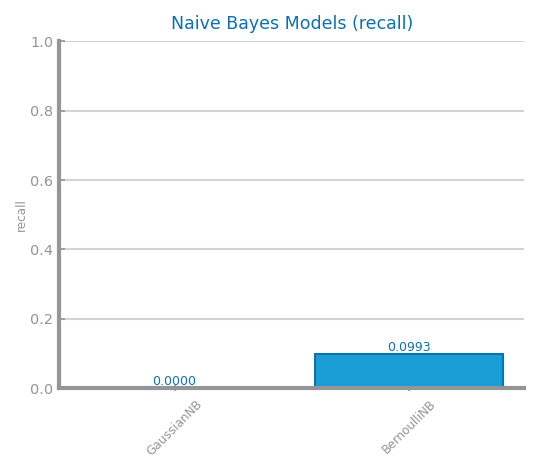

Best NB params: {'name': 'BernoulliNB', 'metric': 'recall', 'params': (), 'recall': 0.09929078014184398}


<Figure size 600x450 with 0 Axes>

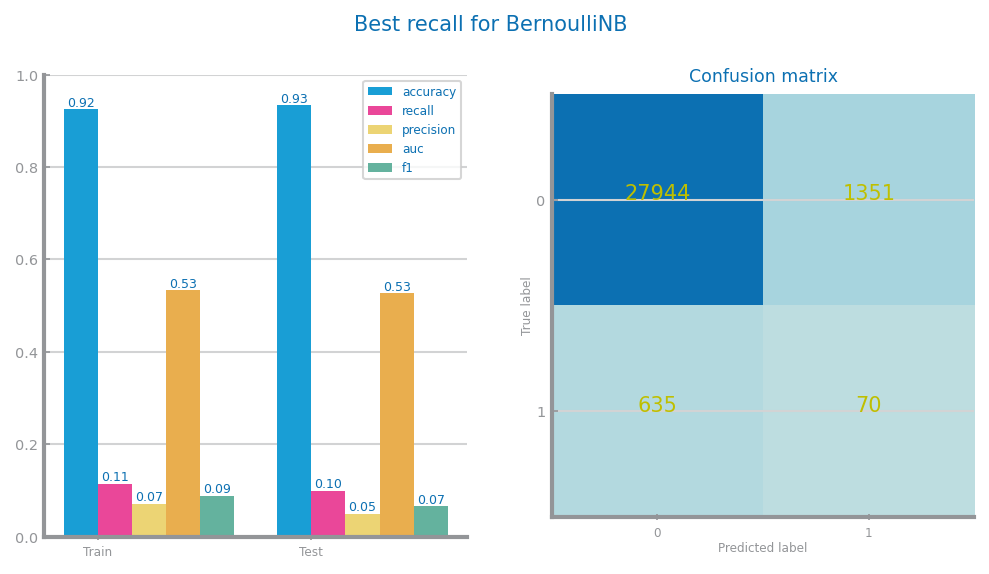

In [23]:
# NB study on simple_mvi dataset
figure()
best_nb_model, nb_params = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=eval_metric)
savefig(f"../../charts/lab3_preparation/mvi/{file_tag}_nb_{eval_metric}_study.png")
show()

print("Best NB params:", nb_params)

# NB confusion matrix + metrics
prd_trn_nb: array = best_nb_model.predict(trnX)
prd_tst_nb: array = best_nb_model.predict(tstX)

figure()
plot_evaluation_results(nb_params, trnY, prd_trn_nb, tstY, prd_tst_nb, labels)
savefig(f"../../charts/lab3_preparation/mvi/{file_tag}_nb_{nb_params['name']}_best_{nb_params['metric']}_eval.png")
show()


In [26]:
# Borrowed from studies.py but adapted for KNN param search and study plot
def knn_study(
    trnX: ndarray, 
    trnY: array, 
    tstX: ndarray, 
    tstY: array, 
    k_max: int=19, 
    lag: int=2, 
    metric='accuracy'
) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params["params"][0]} and {best_params["params"][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

In [28]:
# KNN param search + study plot
figure()
best_knn, knn_params = knn_study(trnX, trnY, tstX, tstY, k_max=20, metric=eval_metric)
#savefig(f"../../charts/lab3_preparation/mvi/{file_tag}_knn_{eval_metric}_study.png")
#show()

# KNN confusion matrix + metrics
prd_trn_knn = best_knn.predict(trnX)
prd_tst_knn = best_knn.predict(tstX)

figure()
plot_evaluation_results(
    knn_params,
    trnY,
    prd_trn_knn,
    tstY,
    prd_tst_knn,
    labels,
)
savefig(f"../../charts/lab3_preparation/mvi/{file_tag}_knn_{knn_params['name']}_best_{knn_params['metric']}_eval.png")
show()

KeyboardInterrupt: 

<Figure size 600x450 with 0 Axes>

# Saving Updated Data with Best Method

<i>MVI didn't do any significant change, since only one column had missing values, and it was 0.77% missing values. Arbitrary which method to choose? Tail_Number shouldnt mean anything anyway.</i>

In [20]:
output_train_path = "../../data/prepared/mvi/flight_train_mvi.csv"
output_test_path  = "../../data/prepared/mvi/flight_test_mvi.csv"

print("Saving SIMPLE-MVI train data to:", output_train_path)
print("Saving SIMPLE-MVI test data to:",  output_test_path)

train_simple.to_csv(output_train_path, index=False)
test_simple.to_csv(output_test_path, index=False)

print("\nSaved MVI datasets:")
print("  Train →", output_train_path, "shape:", train_simple.shape)
print("  Test  →", output_test_path,  "shape:", test_simple.shape)

Saving SIMPLE-MVI train data to: ../../data/prepared/mvi/flight_train_mvi.csv
Saving SIMPLE-MVI test data to: ../../data/prepared/mvi/flight_test_mvi.csv

Saved MVI datasets:
  Train → ../../data/prepared/mvi/flight_train_mvi.csv shape: (140000, 182)
  Test  → ../../data/prepared/mvi/flight_test_mvi.csv shape: (60000, 182)
